In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
def sign_corr(x):
    s = np.sign(x)
    s[x==0] = (-1)**rng.integers(2, size=s[x==0].shape)
    return s

#INF_CONDITION = [0, 692];
def phi(x):
    y = np.where(x > 1e-300, np.log(1 / np.tanh(x / 2)), 692)
    return y

In [3]:
# density evolution of a simple regular LDPC code with the particle method
# (population dynamics)
def PDF_Evolution_MonteCarlo_BSC():
    dv = 3
    dc = 6
    delta = 0.05

    # number of decoding iterations
    iterations = 10

    # slows down quite a lot! Use with care and only for debugging
    display_histogram = True

    # population size
    N = 1000 #1000000

    # all-zero codeword (+1) with errors
    z = 1 - 2 * (np.random.rand(N) < delta)

    Lc = np.log((1 - delta) / delta)

    LLRs = z * Lc

    CN_messages = np.zeros(shape=N)
    VNh = []
    VXh = []
    CNh = []
    CXh = []

    for i in tqdm(range(iterations)):
        # compute VN to CN messages
        if i == 0:
            VN_messages = LLRs
        else:
            # VN operation
            VN_messages = LLRs[rng.integers(N, size=N)] + np.sum(CN_messages[rng.integers(N, size=(N, dv-1))], axis=1)
        
        if display_histogram:
            # histograms for display/debug purposes
            if i <= 1:
                um, counts = np.unique(VN_messages, return_counts=True)
                VNh.append(counts / counts.sum())
                VXh.append(um)
            else:
                bins = np.arange(-10, 30.5, 0.5)
                H, edges = np.histogram(VN_messages, bins=bins, density=True)
                VNh.append(H) # store count of bins
                VXh.append(0.5 * (edges[:-1] + edges[1:])) # calculate bin centers
                plt.show()

        if (not display_histogram) and (np.all(VN_messages > 0)):
            # no more errors, abort
            print(f"No errors after {i} iterations")
            break

        CN_messages = np.zeros(shape=N)
        # here, implement the sum product rule
        idx = rng.integers(N, size=(N, dc-1))
        CN_messages = phi(np.sum(phi(np.abs(VN_messages[idx])), axis=1)) * np.prod(sign_corr(VN_messages[idx]), axis=1)

        if display_histogram:
            if i <= 1:
                um, counts = np.unique(CN_messages, return_counts=True)
                CNh.append(counts / counts.sum())
                CXh.append(um)
            else:
                bins = np.arange(-10, 30.5, 0.1)
                H, edges = np.histogram(CN_messages, bins=bins, density=True)
                CNh.append(H) # store count of bins
                CXh.append(0.5 * (edges[:-1] + edges[1:])) # calculate bin centers
                plt.show()
        
        if np.all(VN_messages > 0):
            # no more errors, abort
            print(f"No errors")
            break
    
    if display_histogram:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        for k in range(i):
            if k <= 1:
                plt.stem(VXh[k], VNh[k])
            else:
                plt.plot(VXh[k], VNh[k])
        plt.title("VN")
        #plt.grid()

        plt.subplot(1,2,2)
        for k in range(i):
            if k <= 1:
                plt.stem(CXh[k], CNh[k])
            else:
                plt.plot(CXh[k], CNh[k])
        plt.title("CN")
        #plt.grid()

        plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

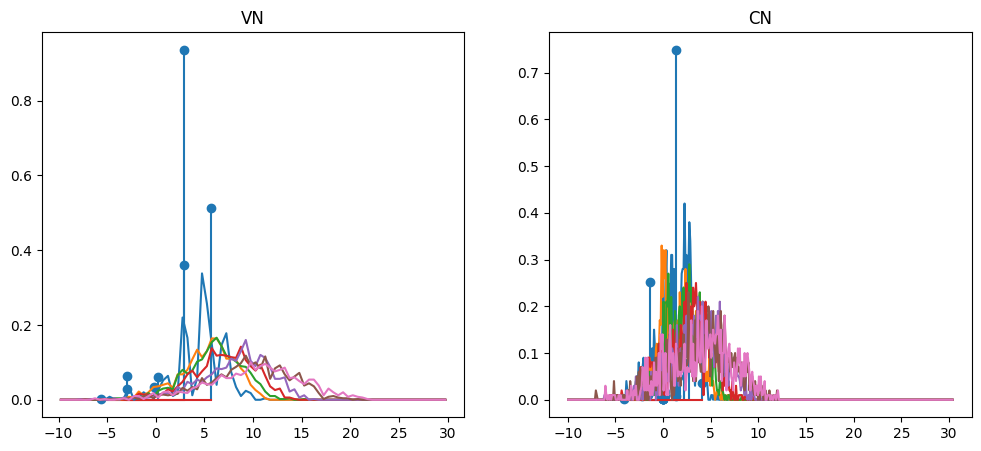

In [15]:
PDF_Evolution_MonteCarlo_BSC()